# Article code with 3 actions (DN, CM, PM)

In [1]:
import numpy as np
import random
from random import sample
import math 

In [2]:
z = 10 #Degradation threshold

def state(amount):
    new_state = []    
    if (amount >= 0 and amount <3):
        new_state = 0 # healthy1
    
    if (amount >= 3 and amount <7):
        new_state = 1 # healthy2
        
    if (amount >= 7 and amount < z ):
        new_state = 2 #healthy3 
        
    if (amount >= z):
        new_state = 3 # fail
    
    return new_state

In [3]:
def Rewardfun(degradation):
    Reward=np.zeros((4,)+(3,))
    Reward[: , 0] = -50 # inspection 
    Reward[3,0] = -1050 # inspection + CM
    Reward[: , 1] = -550  # inspection + PM
    Reward[3,1] = -1550   # inspection + CM + PM
    Reward[: , 2] = -1050 # inspection + CM 
    Reward[3,2] = -1050 # inspection + CM 
    # notice that if we are in state 3, we just choose action 2  
    return Reward

In [4]:
a = 8

def Envirenment(degradation , action):
   
    n2 = np.random.poisson((1-0.001)*4, 1) # number of effective shock
    w2 = np.random.gamma(0.6, 1.2, n2) # magnitude of effective shock
    magnitude = sum(w2)
    next_state = 0
    reward = 0
    
    if action == 0 :#do nothing
        
            degradation += (magnitude + 3)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
        
    if action == 1 :#PM
        
           # decay = degradation*np.random.beta(0.5, 1, 1)
            #decay = degradation/z
            #degradation -= decay*degradation
            degradation = (magnitude + 2.85)/a #replace due to PM
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
                    
    if action == 2 : # CM 
        
            degradation = (magnitude + 2.65)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
       
    
    return next_state , reward , degradation

In [12]:
def choose_action(epsilon,current_state):
    if current_state == 3 :
        return 2 #CM
    else:
        if (np.random.random() < epsilon):
            return random.choice([0,1]) # we just choose PM and DN  
        else:
            return np.argmax(Q_table[current_state])

In [13]:
num_episodes=2000
discount=0.88

In [14]:
epsilon = 1
learning_rate = 1

Q_table = np.zeros((4, ) + (3,))

Q_table[3,0]= -100000000
Q_table[3,1]= -100000000
scores = []
# Looping for each episode
for e in range(3000):
    # Initializes the state
    current_state = 0 #it is new
    degradation = 0  #it is new
    rewards = []
       
    # Looping for each step
    for j in range(50 +1):
        # Choose A from S
        action = choose_action2(epsilon,current_state)
        # Take action
        obs , reward , degradation  = Envirenment(degradation,action)
        rewards.append(reward)
        new_state = obs
        # Update Q(S,A)
        Q_table[current_state][action] += (learning_rate * 
                                        (reward 
                                         + discount * np.max(Q_table[new_state]) 
                                         - Q_table[current_state][action]))
        current_state = new_state
        
    learning_rate *= 0.99
    epsilon *= 0.99
    scores.append(sum(rewards))

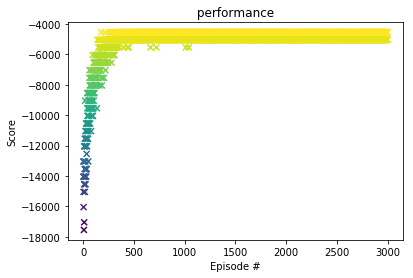

In [15]:
# Plot the policy performance
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance ')
plt.show()

In [16]:
optimal_value =[]
current_state = 0 #it is new
degradation = 0
optimal_cost = []
expected_optimal_cost=[]

for j in range(20+1):
     #Choose A from S
    action = np.argmax(Q_table[current_state])
    if action == 1:
        optimal_value.append(degradation)    
    # Take action
    current_state, reward ,degradation = Envirenment(degradation,action)
    optimal_cost.append(-reward)
    #print(optimal_cost)
    if any(np.array(optimal_cost) > 50):
        expected_optimal_cost.append(np.mean(optimal_cost))
    if action ==1:
          optimal_cost = []
    print (reward ,degradation , action)

print(optimal_value)
print(expected_optimal_cost)
print("optimal degradation for repair=",np.mean(optimal_value))
print("cost for repair =",np.mean(expected_optimal_cost))

-50.0 0.828767483034077 0
-50.0 1.2704948035842585 0
-50.0 1.6890578871919035 0
-50.0 2.6708479565781973 0
-50.0 4.254830129442343 0
-50.0 4.887859724990112 0
-50.0 5.476187733243006 0
-50.0 6.393757292330217 0
-50.0 7.090070060348911 0
-550.0 0.3828096995909446 1
-50.0 0.9272982619223845 0
-50.0 1.7420521918499738 0
-50.0 2.4783298618360776 0
-50.0 3.192583257737253 0
-50.0 3.6273700154440958 0
-50.0 4.695311858165303 0
-50.0 5.21224734851561 0
-50.0 6.303167705601618 0
-50.0 6.79863595502481 0
-50.0 7.894568638850611 0
-550.0 0.39758865261907916 1
[7.090070060348911, 7.894568638850611]
[100.0, 95.45454545454545]
optimal degradation for repair= 7.492319349599761
cost for repair = 97.72727272727272


# QL

In [17]:
epsilon = 1
learning_rate = 1

Q_table = np.zeros((4, ) + (3,))
old_Q = 0
Q_table[3,0]= -100000000
Q_table[3,1]= -100000000
scores = []
deltas = []

# Looping for each episode
for e in range(1000):
    # Initializes the state
    current_state = 0 #it is new
    degradation = 0  #it is new
    rewards = []
    biggest_change = 0
       
    # Looping for each step
    for j in range(50 +1):
        # Choose A from S
        action = choose_action(epsilon,current_state)
        # Take action
        obs , reward , degradation  = Envirenment(degradation,action)
        rewards.append(reward)
        new_state = obs
        
        old_Q = Q_table[current_state][action] 
        # Update Q(S,A)
        Q_table[current_state][action] += (learning_rate * 
                                        (reward 
                                         + discount * np.max(Q_table[new_state]) 
                                         - Q_table[current_state][action]))
        
        biggest_change = max(biggest_change, np.abs(old_Q - Q_table[current_state][action]))
        current_state = new_state
        
    learning_rate *= 0.99
    epsilon *= 0.99
    scores.append(sum(rewards))
    deltas.append(biggest_change)

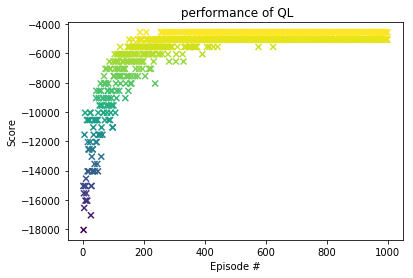

In [18]:
# Plot the policy performance
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance of QL')
plt.show()

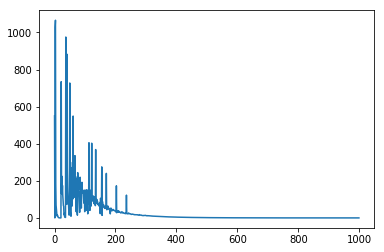

In [19]:
import matplotlib.pyplot as plt
plt.plot(deltas)
plt.show()

In [20]:
optimal_value =[]
current_state = 0 #it is new
degradation = 0
optimal_cost = []
expected_optimal_cost=[]

for j in range(2000+1):
     #Choose A from S
    action = np.argmax(Q_table[current_state])
    if action == 1:
        optimal_value.append(degradation)    
    # Take action
    current_state, reward ,degradation = Envirenment(degradation,action)
    optimal_cost.append(-reward)
    #print(optimal_cost)
    if any(np.array(optimal_cost) > 50):
        expected_optimal_cost.append(np.mean(optimal_cost))
    if action ==1:
          optimal_cost = []
    #print (reward ,degradation , action)

#print(optimal_value)
#print(".................")
#print(expected_optimal_cost)
#print(".................")
print("optimal degradation for repair=",np.mean(optimal_value))
print(".................")
print("cost for repair =",np.mean(expected_optimal_cost))

optimal degradation for repair= 7.407939842754047
.................
cost for repair = 99.5028333489872


# SARSA

In [21]:
epsilon = 1
learning_rate = 1

Q_table = np.zeros((4, ) + (3,))
old_Q = 0

Q_table[3,0]= -100000000
Q_table[3,1]= -100000000
scores = []
deltas = []
# Looping for each episode
for e in range(1000):
    # Initializes the state
    current_state = 0 #it is new
    degradation = 0  #it is new
    action = choose_action(epsilon,current_state)
    rewards = []
    biggest_change = 0   
    # Looping for each step
    for j in range(50 +1):
        # Take one step in the environment
        next_state , reward , degradation  = Envirenment(degradation,action)
        
        # choose the next action (needed for the SARSA update)
        next_action = choose_action(epsilon, next_state)
        
        rewards.append(reward)
        old_Q = Q_table[current_state][action]
        # SARSA Update
        Q_table[current_state][action] += (learning_rate * 
                                        (reward 
                                         + discount * Q_table[next_state][next_action]
                                         - Q_table[current_state][action]))
        
        biggest_change = max(biggest_change, np.abs(old_Q - Q_table[current_state][action]))
        
        current_state = next_state
        action = next_action
        
    learning_rate *= 0.99
    epsilon *= 0.99
    scores.append(sum(rewards))
    deltas.append(biggest_change)

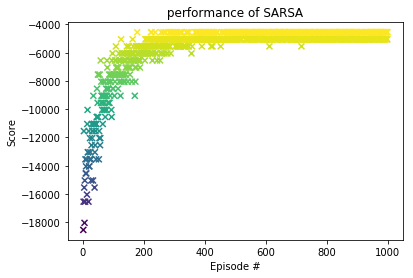

In [22]:
# Plot the policy performance
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance of SARSA ')
plt.show()

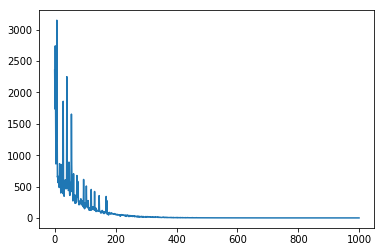

In [23]:
import matplotlib.pyplot as plt
plt.plot(deltas)
plt.show()

In [24]:
optimal_value =[]
current_state = 0 #it is new
degradation = 0
optimal_cost = []
expected_optimal_cost=[]

for j in range(2000+1):
     #Choose A from S
    action = np.argmax(Q_table[current_state])
    if action == 1:
        optimal_value.append(degradation)    
    # Take action
    current_state, reward ,degradation = Envirenment(degradation,action)
    optimal_cost.append(-reward)
    #print(optimal_cost)
    if any(np.array(optimal_cost) > 50):
        expected_optimal_cost.append(np.mean(optimal_cost))
    if action ==1:
          optimal_cost = []
    #print (reward ,degradation , action)

#print(optimal_value)
##print(".................")
#print(expected_optimal_cost)
#print(".................")
print("optimal degradation for repair=",np.mean(optimal_value))
print(".................")
print("cost for repair =",np.mean(expected_optimal_cost))

optimal degradation for repair= 7.43295231419444
.................
cost for repair = 100.69967720721489


# MCRL

In [25]:
ALL_POSSIBLE_ACTIONS = [0,1,2]
def policy_using_pi(St, pi):
    return np.random.choice(ALL_POSSIBLE_ACTIONS, p=[pi[(St,a)] for a in ALL_POSSIBLE_ACTIONS])

In [26]:
def choose_action(current_state, pi):
    if current_state == 3 :
        return 2 #CM
    else:
        return policy_using_pi(current_state, pi)  #epsilon_soft       

In [27]:
GAMMA =  0.9
def play_episode(pi):
    #S0,A0,R1,S1,A1,R2,S2,A2,R3 ,...
    s = 0 #it is new
    d = 0 #it is new
    a= choose_action(s, pi)
    
    #r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [((s, a, 0))]
    
    for j in range(50 +1):
    
        s , r ,d  = Envirenment(d,a)
        if (j == 50):
            states_actions_rewards.append((s, None, r))
        else:
            a= choose_action(s, pi)
            states_actions_rewards.append((s,a, r))
            
    
     # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        
       # the value of the terminal state is 0 by definition
       # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    
    return states_actions_returns 


In [33]:
from collections import defaultdict
epsilon = 1
learning_rate = 1
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((4, ) + (3,))
old_Q = 0 

Q[3,0]= -100000000
Q[3,1]= -100000000

returns =np.zeros((4,) + (3,))
N = np.zeros((4 ,) + (3,))

deltas = []


for epi in range(100 +1):# Looping through episodes 
    
    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_episode(pi)
    
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
    
        state_action = (s,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s][a] += G
            N[s][a] +=1
            old_Q = Q[s][a]    
            Q[s][a] = returns[s][a] /N[s][a] # Average reward across episodes
            
            biggest_change = max(biggest_change, np.abs(old_Q - Q[s][a]))
            seen_state_action_pairs.add(state_action)
              
            #for each s in the episode         
            A_star = np.argmax(Q[s])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                     
    
    learning_rate *= 0.99
    epsilon *= 0.99               
    deltas.append(biggest_change)
                  

C:\Users\ARYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\ARYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ARYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\ARYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


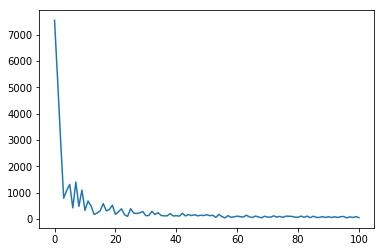

In [34]:
import matplotlib.pyplot as plt
plt.plot(deltas)
plt.show()

In [35]:
optimal_value =[]
current_state = 0 #it is new
degradation = 0
optimal_cost = []
expected_optimal_cost=[]

for j in range(20+1):
     #Choose A from S
    action = np.argmax(Q[current_state])
    if action == 1:
        optimal_value.append(degradation)    
    # Take action
    current_state, reward ,degradation = Envirenment(degradation,action)
    optimal_cost.append(-reward)
    #print(optimal_cost)
    if any(np.array(optimal_cost) > 50):
        expected_optimal_cost.append(np.mean(optimal_cost))
    if action ==1:
          optimal_cost = []
    #print (reward ,degradation , action)

print(optimal_value)
print(".................")
print(expected_optimal_cost)
print(".................")
print("optimal degradation for repair=",np.mean(optimal_value))
print(".................")
print("cost for repair =",np.mean(expected_optimal_cost))

[]
.................
[1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0, 1050.0]
.................
optimal degradation for repair= nan
.................
cost for repair = 1050.0


C:\Users\ARYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
C:\Users\ARYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
